BUILDING MODEL WITH BEST HYPER PARAMETARS

In [26]:
import optuna
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("Data/df_long_processed.csv")

In [10]:

# Ensure Date column is datetime (critical for time sorting)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Confirm column types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Product  731 non-null    object        
 1   Size     731 non-null    object        
 2   Date     731 non-null    datetime64[ns]
 3   Sales    725 non-null    float64       
 4   lag_1    731 non-null    float64       
 5   lag_2    731 non-null    float64       
 6   lag_3    731 non-null    float64       
 7   lag_12   731 non-null    float64       
 8   roll_3   731 non-null    float64       
 9   roll_6   731 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 57.2+ KB


Define features and target

In [14]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

features = ['Product', 'Size', 'Year', 'Month',
            'lag_1', 'lag_2', 'lag_3', 'lag_12',
            'roll_3', 'roll_6']

target = 'Sales'

df = df.dropna(subset=features + [target])

df['Product'] = df['Product'].astype(str)
df['Size'] = df['Size'].astype(str)

X = df[features]
y = df[target]

cat_features = ['Product', 'Size']


Define the Optuna objective function

In [15]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1200),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_seed': 42,
        'loss_function': 'RMSE',
        'early_stopping_rounds': 50,
        'verbose': 0
    }

    tscv = TimeSeriesSplit(n_splits=4)
    rmse_scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True)
        preds = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


Run the Optuna optimization

In [16]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # increase trials for more robust tuning

print("Best Trial:")
print(f"  RMSE: {study.best_trial.value:.2f}")
print("  Params:")
for k, v in study.best_trial.params.items():
    print(f"    {k}: {v}")


[I 2025-07-08 20:28:23,636] A new study created in memory with name: no-name-966fc4da-f555-44ed-862c-73033da64307
[I 2025-07-08 20:28:34,523] Trial 0 finished with value: 619101.9658273496 and parameters: {'iterations': 1119, 'depth': 5, 'learning_rate': 0.06927322111217066, 'l2_leaf_reg': 0.03649253340962642}. Best is trial 0 with value: 619101.9658273496.
[I 2025-07-08 20:28:51,970] Trial 1 finished with value: 630430.4825797983 and parameters: {'iterations': 249, 'depth': 9, 'learning_rate': 0.23961786204473187, 'l2_leaf_reg': 2.4975989579509283}. Best is trial 0 with value: 619101.9658273496.
[I 2025-07-08 20:29:20,630] Trial 2 finished with value: 627466.2053068201 and parameters: {'iterations': 360, 'depth': 9, 'learning_rate': 0.08853400979683748, 'l2_leaf_reg': 0.05360005851103949}. Best is trial 0 with value: 619101.9658273496.
[I 2025-07-08 20:29:53,342] Trial 3 finished with value: 640901.0652283621 and parameters: {'iterations': 722, 'depth': 10, 'learning_rate': 0.09119397

Best Trial:
  RMSE: 613236.12
  Params:
    iterations: 204
    depth: 5
    learning_rate: 0.29544977361584684
    l2_leaf_reg: 0.1837840368605683


In [18]:
# Get best params and retrain final model
best_params = study.best_trial.params
best_params.update({
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100
})

final_model = CatBoostRegressor(**best_params)
final_model.fit(Pool(X, y, cat_features=['Product', 'Size']))


0:	learn: 785650.6669132	total: 25ms	remaining: 5.08s
100:	learn: 11467.2804357	total: 3.02s	remaining: 3.08s
200:	learn: 4881.8372034	total: 5.33s	remaining: 79.5ms
203:	learn: 4832.5134611	total: 5.39s	remaining: 0us


In [21]:
y_pred = final_model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Evaluation Results:")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAE:  {mae:,.2f}")
print(f"  R²:   {r2:.4f}")

Evaluation Results:
  RMSE: 18,324.10
  MAE:  7,161.14
  R²:   0.9997


In [22]:
final_model.save_model("catboost_sales_model.cbm")
print("Model saved as 'catboost_sales_model.cbm'")

Model saved as 'catboost_sales_model.cbm'


In [23]:
model_loaded = CatBoostRegressor()
model_loaded.load_model("Models/catboost_sales_model.cbm")

In [24]:
importances = final_model.get_feature_importance()
feature_names = final_model.feature_names_

for name, score in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name:12s} : {score:.2f}")


lag_1        : 48.19
lag_2        : 13.13
roll_6       : 11.30
lag_3        : 9.17
roll_3       : 8.23
Product      : 7.11
Month        : 2.45
Size         : 0.18
lag_12       : 0.17
Year         : 0.07


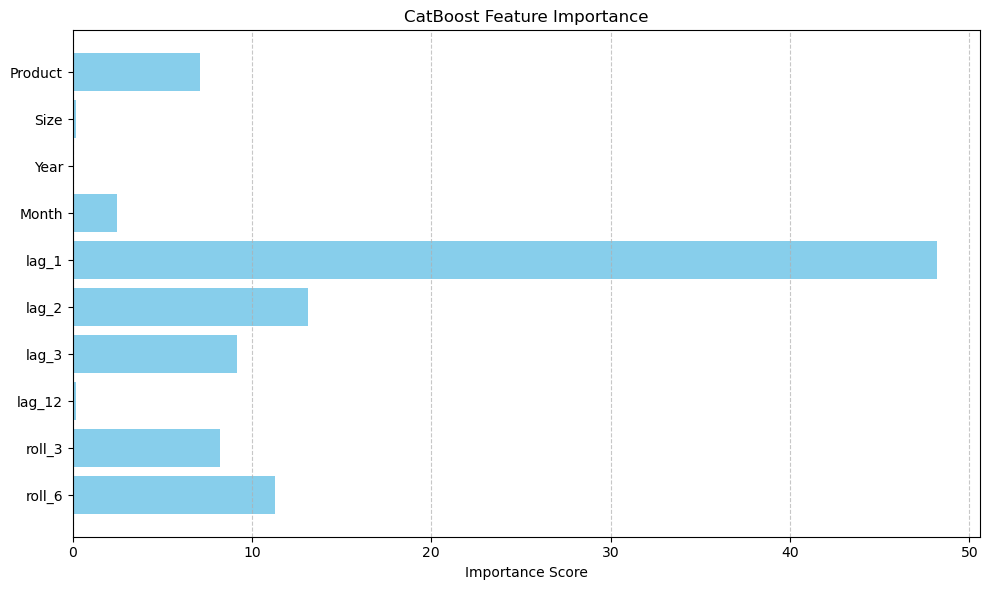

In [27]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance Score")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
